In [239]:
import pandas as pd
import yfinance as yf
import datetime as dt
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [240]:
tickers = ['SPY', 'QQQ', 'GLD', 'BND', 'VXUS']

years = 10
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=years*365)

adjClosed = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start=startDate, end=endDate)
    adjClosed[ticker] = data['Close']

adjClosed


/var/folders/0x/6ycvsk251gzgt9yyt7nztpk40000gn/T/ipykernel_56790/3286032201.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=startDate, end=endDate)
[*********************100%***********************]  1 of 1 completed
/var/folders/0x/6ycvsk251gzgt9yyt7nztpk40000gn/T/ipykernel_56790/3286032201.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=startDate, end=endDate)
[*********************100%***********************]  1 of 1 completed
/var/folders/0x/6ycvsk251gzgt9yyt7nztpk40000gn/T/ipykernel_56790/3286032201.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=startDate, end=endDate)
[*********************100%***********************]  1 of 1 completed
/var/folders/0x/6ycvsk251gzgt9yyt7nztpk40000gn/T/ipykernel_56790/3286032201.py:9: FutureWarning: YF.download() has changed argument auto

,SPY,QQQ,GLD,BND,VXUS
Date,,,,,
2015-07-13,176.830658,101.574188,110.989998,60.980713,37.597656
2015-07-14,177.597794,102.241837,110.739998,61.093887,37.850842
2015-07-15,177.538773,102.353111,110.160004,61.267380,37.627445
2015-07-16,178.963425,103.799637,109.760002,61.267380,37.910419
2015-07-17,179.115143,105.329666,108.650002,61.274879,37.835945
...,...,...,...,...,...
2025-06-30,617.849976,551.640015,304.829987,73.394997,69.089996
2025-07-01,617.650024,546.989990,307.549988,73.339996,69.110001
2025-07-02,620.450012,550.799988,309.250000,73.260002,69.330002


1. Mixes risk and safety. Suitable for long-term investors.
2. High potential return but also high risk. Focus on QQQ.
3. Lower risk, prioritizing bonds and gold. More stable.


In [241]:
balancedWeights   = np.array([0.30, 0.20, 0.20, 0.20, 0.10])  # SPY, QQQ, GLD, BND, VXUS
techHeavyWeights  = np.array([0.10, 0.50, 0.10, 0.10, 0.20])  # typo fixed: tech not teach
lowRiskWeights    = np.array([0.10, 0.10, 0.25, 0.40, 0.15])

Performance metrics, these depend on logreturns and covmatrix and important on WEIGHTS of portfolio

In [242]:
logReturns = np.log(adjClosed/adjClosed.shift(1))
logReturns = logReturns.dropna()
covMatrix = logReturns.cov()
riskFreeRate = 0.036

def expectedLogReturn(weights, logReturns):
    return np.sum(weights*logReturns.mean())

def standardDeviation(weights, covMatrix):
    variance = weights.T @ covMatrix @ weights
    return np.sqrt(variance)

def simpleReturn(weights,logReturns):
    return np.exp(expectedLogReturn(weights, logReturns)) 

def SharpeRatio(weights, logReturns, covMatrix, riskFreeRate):
    return (simpleReturn(weights, logReturns) - riskFreeRate)/standardDeviation(weights,covMatrix)

Calculate each historic logreturn and standard dev of these portfolios

In [243]:
balancedWeightsReturns = expectedLogReturn(balancedWeights, logReturns)
balancedWeightsStandardDeviation = standardDeviation(balancedWeights, covMatrix)
teachHeavyWeightsReturns = expectedLogReturn(techHeavyWeights, logReturns)
teachHeavyWeightsStandardDeviation = standardDeviation(techHeavyWeights, covMatrix)
lowRiskWeightsReturns = expectedLogReturn(lowRiskWeights, logReturns)
lowRiskWeightsStandardDeviation = standardDeviation(lowRiskWeights, covMatrix)


In [244]:
def randomZ():
    return np.random.normal(0,1)

Input special log return, and add a randomness attribute with a randomised z score to simulate volatility

In [245]:
def scenarioGainLoss(weightedLogReturns, weightedStandardDeviation, days, portfolioValue, zScore):
    totalLogReturns = weightedLogReturns * days 
    randomnessLog =  zScore * np.sqrt(days) * weightedStandardDeviation
    return portfolioValue * np.exp(totalLogReturns+randomnessLog)



In [246]:
simulations = 10000
scenarioReturn = np.zeros((3,simulations))
portfolioValue = 1000
days = 252



for j in range(simulations):
    z = randomZ()
    scenarioReturn[0,j] = scenarioGainLoss(balancedWeightsReturns, balancedWeightsStandardDeviation, days, portfolioValue, z)


for j in range(simulations):
    z = randomZ()
    scenarioReturn[1,j] = scenarioGainLoss(teachHeavyWeightsReturns, teachHeavyWeightsStandardDeviation, days, portfolioValue, z)

for j in range(simulations):
    z = randomZ()
    scenarioReturn[2,j] = scenarioGainLoss(lowRiskWeightsReturns, lowRiskWeightsStandardDeviation, days, portfolioValue, z) 



In [247]:
alpha = 0.95
VaRBalanced = np.percentile(scenarioReturn[0,:], 100*(1-alpha))
cVaRBalanced = np.mean(scenarioReturn[0,scenarioReturn[0] <= VaRBalanced])
VaRTech = np.percentile(scenarioReturn[1,:], 100*(1-alpha))
cVaRTech = np.mean(scenarioReturn[1,scenarioReturn[1] <= VaRTech])
VaRLowRisk = np.percentile(scenarioReturn[2,:], 100*(1-alpha))
cVaRLowRisk = np.mean(scenarioReturn[2,scenarioReturn[2] <= VaRLowRisk])

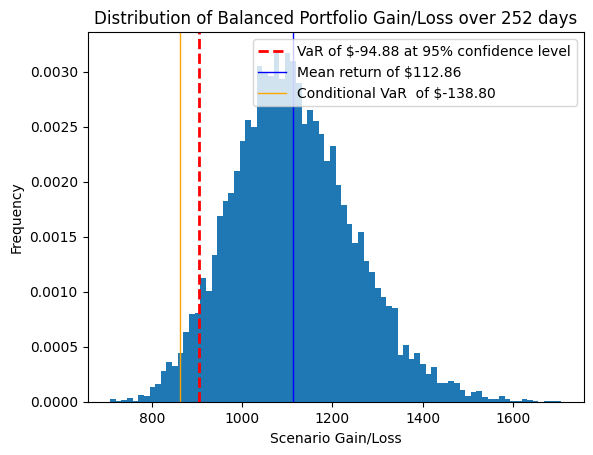

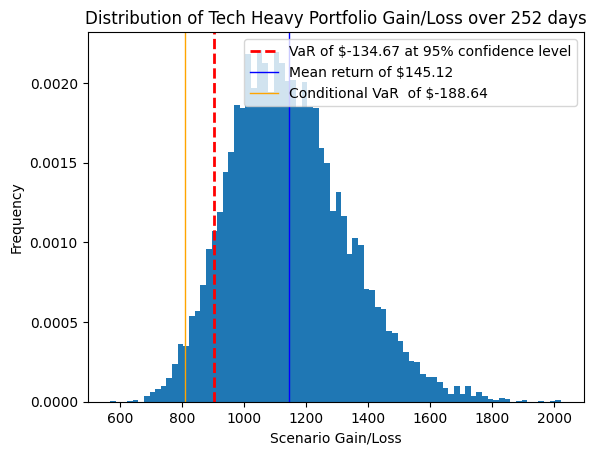

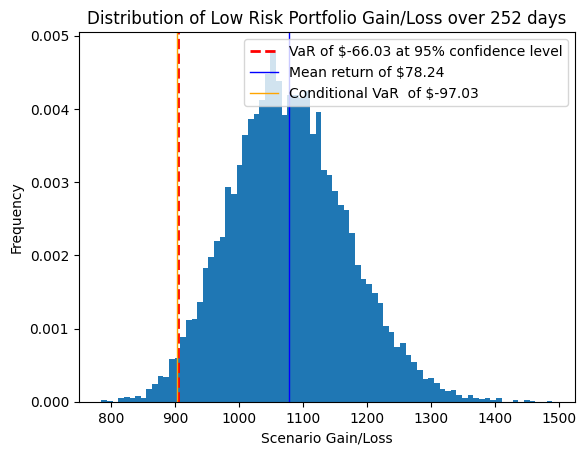

In [249]:
def plotGraph(portfolioType, order, VaRType, cVaR):
    mean = np.mean(scenarioReturn[order,:])

    plt.hist(scenarioReturn[order,:],bins = 80, density=True)
    plt.xlabel('Scenario Gain/Loss')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {portfolioType} Portfolio Gain/Loss over {days} days')
    plt.axvline(VaRBalanced, color = 'r',linestyle = 'dashed', linewidth = '2', label = f'VaR of ${(VaRType - portfolioValue):.2f} at {alpha:.0%} confidence level')
    plt.axvline(mean, color = 'blue', linestyle = 'solid', linewidth = '1', label = f'Mean return of ${(mean - portfolioValue):.2f}')
    plt.axvline(cVaR, color = 'orange', linestyle = 'solid', linewidth = '1', label = f'Conditional VaR  of ${(cVaR - portfolioValue):.2f}')
    plt.legend()
    plt.show()

plotGraph('Balanced', 0, VaRBalanced, cVaRBalanced)
plotGraph('Tech Heavy', 1, VaRTech,cVaRTech)
plotGraph('Low Risk', 2, VaRLowRisk, cVaRLowRisk)